# Analyzing intraday and overnight stock returns with pandas
I recently saw some [chatter](https://www.reddit.com/r/Superstonk/comments/s2a8fh/they_still_havent_told_you/) about a technical [paper](https://arxiv.org/pdf/2201.00223.pdf) discussing the contrast between overnight and intraday stock returns. In the paper, we learn that overnight stock returns far outpace returns seen intraday during regular trading hours. In other words, stocks move the most when markets are not open, but when trading is taking place, the net returns seem to be close to zero. The paper claims this is a conspiracy where large hedge funds are manipulating the market. In this article, I will try to recreate the basic results from the article and look at one part of overnight returns that the article doesn't discuss.

In response to the paper, I've seen a few people give reasons for why overnight returns are larger, and in future articles I hope to look at a few of them. But in this first article, I only want to cover a few basics.

1. Reproduce the basic results seen in the paper, using two different data sources
1. If any inconsistencies come up, resolve them

It turns out that covering these two basic steps will give us plenty to work with for one article. In the process, we'll use two sources of stock price data, make a mistake along the way, learn about stock dividends, and build a vectorized calculation.  Let's get started.

## The premise
First, I'd encourage you to consider glancing through the paper. Many times, reading a technical paper can be a good source of ideas, even if the paper has some flaws. In this case, the author provides some links to source code, so you can attempt to reproduce his results directly. I did download and run the code after some code changes to upgrade a few to Python 3. But in this case, I think it's easier to try to reproduce the data from scratch since it's a simple calculation.

To start with, I'll be getting data from AlphaVantage, and you can read more about it and how to get your own data in [my earlier](https://www.wrighters.io/financial-market-data-analysis-with-pandas/) [articles](https://www.wrighters.io/analyzing-stock-data-events-with-pandas/). In those articles, I also talk a bit about SPY, the S&P 500 Exchange Traded Fund (ETF). We'll use that as our example data.

So let's get data first, and plot the close price of SPY.

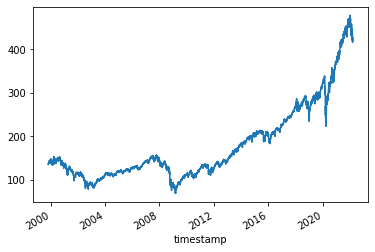

In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt

try:
    API_KEY = open(os.path.expanduser("~/.alphavantage.key"), 'r').readline().strip()
except Exception as ex:
    print("Put your AlphaVantage API key in the file '.alphavantage.key' in your home directory: ", ex)
    API_KEY = "demo"

def get_daily_bars(symbol):
    function = "TIME_SERIES_DAILY"          # daily data
    outputsize = "full"                     # all of it
    datatype = "csv"                        # CSV - comma separated values
    url = f"https://www.alphavantage.co/query?function={function}&symbol=SPY&outputsize=full&apikey={API_KEY}&datatype={datatype}"
    return pd.read_csv(url, parse_dates=['timestamp'], index_col='timestamp').sort_index()

spy_daily = get_daily_bars("SPY")

spy_daily['close'].plot();

And as we did in previous articles, let's plot the regular return. We'll call this the 'close to close' return, or the return seen by looking only at consecutive close prices. The close price is the price at the end of the regular trading session each day. We'll use a simple percent return here.

<AxesSubplot:xlabel='timestamp'>

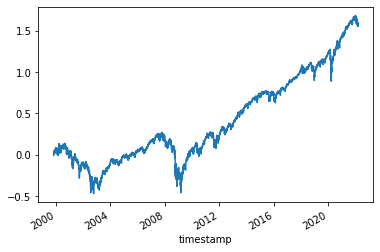

In [2]:
spy_daily['close_to_close_return'] = spy_daily['close'].pct_change()
spy_daily['close_to_close_return'].cumsum().plot()

## Intraday returns
The paper talks about the difference between intraday and overnight returns. An intraday return for a given day is the return generated from the beginning of trading that day (the open) to the end of trading that same day (the close). One way to do this is to subtract the open price from the close price, dividing it by the open price. You can also rearrange terms for a slightly simpler expression.

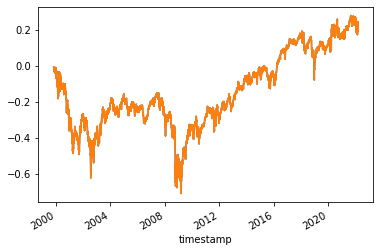

In [3]:
# for intraday return, we want the return from open to close
# one way
spy_daily['open_to_close_return'] = (spy_daily['close'] - spy_daily['open'])/spy_daily['open']
spy_daily['open_to_close_return'].cumsum().plot()
# can also do it like this (by just re-arranging terms)
(spy_daily['close']/spy_daily['open'] - 1).cumsum().plot();

## Overnight returns
Now an overnight return is generated from the change from the close on one day to the open the next day. To get the close price from the previous day, we use the `Series.shift()` method to move it one day. This shifts the close price forward one day to align with the open price, allowing us to see total overnight returns.

<AxesSubplot:xlabel='timestamp'>

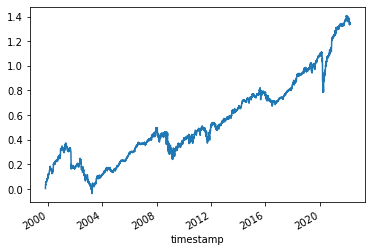

In [4]:
# overnight (close to open) returns
spy_daily['close_to_open_return'] = (spy_daily['open']/spy_daily['close'].shift() - 1).shift()
spy_daily['close_to_open_return'].cumsum().plot()

Now, let's put all of them together on one plot.

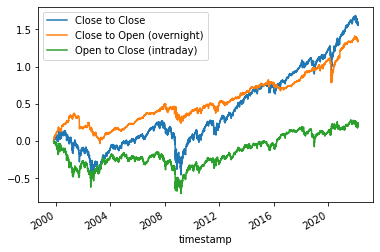

In [5]:
# put them all together
spy_daily['close_to_close_return'].cumsum().plot(label="Close to Close")
spy_daily['close_to_open_return'].cumsum().plot(label="Close to Open (overnight)")
spy_daily['open_to_close_return'].cumsum().plot(label="Open to Close (intraday)")
plt.legend()

## Success?
This looks like we're starting to see plots like suggested in the paper. We can see the total returns in SPY intraday are close to 0, and even negative over large portions of the dataset. The overnight returns are even worse at times, but since 2009, overnight returns are much higher. Interesting.

## Another data source
Now, instead of using AlphaVantage, let's use another free data source, Yahoo! Finance. The author of the paper uses Yahoo! as the source for all of the calculations in the paper, so let's see what that that data looks like. 

I usually use a [nice Python library](https://pypi.org/project/yfinance/) for accessing Yahoo!, it makes for slightly easier to read code and returns data in pandas types. It also gives us a nice way to grab some other interesting data, like splits and dividends. You can install it with `pip install yfinance`.

I'm going to just reproduce the results, but with a second data set.

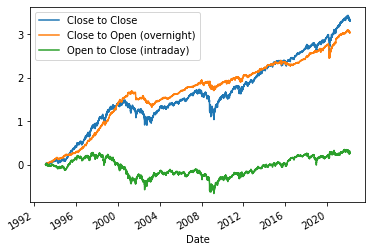

In [6]:
# author used Yahoo! finance for data, so let's do that as well
import yfinance as yf

spy_yf = yf.Ticker("SPY")
spy_yf_hist = spy_yf.history(period="max")

# calc them
spy_yf_hist['close_to_close_return'] = spy_yf_hist['Close'].pct_change()
spy_yf_hist['close_to_open_return'] = spy_yf_hist['Open']/spy_yf_hist['Close'].shift() - 1
spy_yf_hist['open_to_close_return'] = spy_yf_hist['Close']/spy_yf_hist['Open'] - 1

# plot them
spy_yf_hist['close_to_close_return'].cumsum().plot(label="Close to Close")
spy_yf_hist['close_to_open_return'].cumsum().plot(label="Close to Open (overnight)")
spy_yf_hist['open_to_close_return'].cumsum().plot(label="Open to Close (intraday)")
plt.legend()

### Data differences
First of all, we can see that this looks much more dramatic than what we saw in AlphaVantage because the data goes all the way back to 1992. Overnight returns are most of the total returns, and intraday returns are even negative much of the time. One good thing about using Yahoo! data is that we are at least seeing what the paper's author was seeing. Let's compare our data from AlphaVantage to Yahoo!

Note: I cut off the Yahoo! data to be at the same starting date as AlphaVantage. If you have questions about indexing time series data, you can check out [this article](https://www.wrighters.io/indexing-time-series-data-in-pandas/). 

I also make a copy of the data. Curious why I do that? Then [this article](https://www.wrighters.io/views-copies-and-that-annoying-settingwithcopywarning/) might interest you.

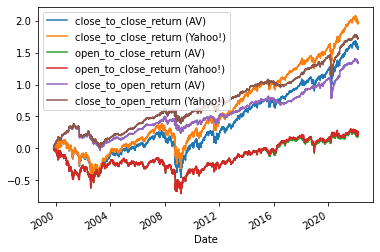

In [7]:
# we make a copy so we can modify it later
spy_yf_short = spy_yf_hist[spy_daily.index[0]:].copy()

for c in ['close_to_close_return', 'open_to_close_return', 'close_to_open_return']:
    spy_daily[c].cumsum().plot(label=f"{c} (AV)")
    spy_yf_short[c].cumsum().plot(label=f"{c} (Yahoo!)")
plt.legend()

We can see that these two returns don't match. Yahoo's returns are higher than AlphaVantage's. Want to know why?

## Corporate Actions
Whenever you are looking at stock price data, it's important to understand whether the prices include splits and dividends, which are also sometimes referred to as _corporate actions_. 

The simplest example is a simple stock split. If the price of the stock is high, the board may decide to split the stock into smaller sizes. So one share of a `$100` stock will become 10 shares of a `$10` stock. If you just look at the price, it appears to have dropped to 1/10 the amount. 

As another example, you may own a stock in a company, and the board of directors decide to split off one of their business divisions as a separate company. The board could decide that each stockholder will get one share of the new company for each share of the old company that the stockholder owns, but the price of the stock will change on the day of the split to reflect this. For example, a `$20` stock might become an `$18` stock, and a new `$2` stock is given to the shareholder. If you *only* look at the price as it was traded, it will look like an extra loss of `$2` on that day. In reality, the stockholders receive a share in the new company, and that share will trade separately going forward. This is oversimplifying a bit, but it's critical that you don't ignore this in your data.

In the case of dividends, a stockholder will receive a dividend payment from the company as long as they own the stock on the last eligible day to receive the dividend, the _ex-dividend_ date. This is typically two days before the dividend is recorded. 

Now why would we care about this? Well, first, this can actually add up to quite a bit of money for some stocks. And since SPY is an Exchange Traded Fund that holds a number of stocks that *do* pay dividends, it also pays a dividend that is the sum of the dividends of the stocks in the ETF. 

Note that AlphaVantage charges extra for a premium service that include dividends in the price history. The prices you get in the data above are the 'as traded' prices. In other words, the price is the exact same price you'd have seen on that day historically, and the dividends are all missing. Yahoo!, on the other hand, gives us the price with the dividend included. 

Now that we know this, the plot above makes sense since only one includes dividends.  Let's add them up. If we sum the returns, how much of the current price is just dividends?

0.19159901587041897
80.485


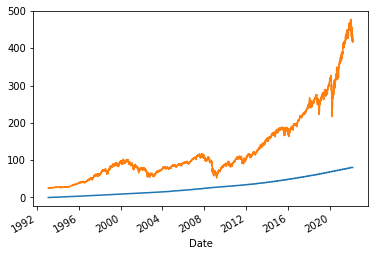

In [8]:
spy_yf_hist['Dividends'].cumsum().plot()
spy_yf_hist['Close'].plot()
print((spy_yf_hist['Dividends'].cumsum()/spy_yf_hist['Close'])[-1])
print(spy_yf_hist['Dividends'].sum())

## One source of overnight returns - dividends
In the data we have since 1992, there has been $80 in dividends paid, about 20% of the price (as of the time running the source notebook).

First, how many dates have dividends? Let's figure this out by finding the rows with a non-zero dividend. If you aren't sure about how indexing works, check out this [first](https://www.wrighters.io/indexing-and-selecting-in-pandas-part-1/) in a series of articles on indexing.  In this case, I create a boolean index selecting rows that aren't 0.

In [9]:
spy_yf_hist.loc[spy_yf_hist['Dividends'] != 0].shape

(117, 10)

There are 117 dividends paid out in the history. Traditionally stocks will pay a dividend quarterly. Let's take a peek at the data when a dividend is paid out in both the AlphaVantage (no dividend) and the Yahoo! (with a dividend) data. Note, I looked at the full data set to get this date.

In [10]:
spy_yf_hist.loc['2021-12-16':'2021-12-20', ['Open', 'Close', 'Dividends', 'close_to_open_return']]

,Open,Close,Dividends,close_to_open_return
Date,,,,
2021-12-16,470.915555,464.816986,0.000,0.004186
2021-12-17,461.549988,459.869995,1.633,-0.007029
2021-12-20,454.480011,454.980011,0.000,-0.011721


In [11]:
spy_daily.loc['2021-12-16':'2021-12-20', ['open', 'close', 'close_to_open_return']]

,open,close,close_to_open_return
timestamp,,,
2021-12-16,472.57,466.45,0.000129
2021-12-17,461.55,459.87,0.004186
2021-12-20,454.48,454.98,-0.010505


Looking at the data, it looks like we can see how the dividend is applied. For the Yahoo! data (the top one), the prices all appear to be adjusted down historically by the amount of the dividend. For the days that a dividend is paid out, you can see that the Yahoo! return is higher than the Alpha Vantage return, because it include the return of the dividend. SPY is just a bunch of stocks put together, and so it pays a dividend that matches the sum of the individual dividends (roughly). So how much of the return is due to dividends alone?

with: 173.23%, without: 134.50, difference: 38.73%


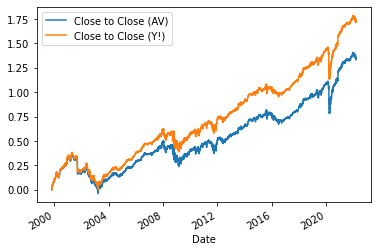

In [12]:
spy_daily['close_to_open_return'].cumsum().plot(label="Close to Close (AV)")
spy_yf_short['close_to_open_return'].cumsum().plot(label="Close to Close (Y!)")
plt.legend()
without_dividends = spy_daily['close_to_open_return'].sum()
with_dividends = spy_yf_short['close_to_open_return'].sum()
print(f"with: {with_dividends * 100:.2f}%, without: {without_dividends* 100:.2f}, difference: {(with_dividends - without_dividends)*100:.2f}%")

So roughly 20% of the overnight returns for SPY are from dividends alone. Obviously, there's still a stark contrast between overnight and intraday returns, which we'll need to continue to think about. But dividends are a large contributing factor. A word search on the paper doesn't even mention them. 

## Double check results
One way to make sure you have the right answer is to double check your results. One way I like to do this is to see if I can transform the data in one data set into the data in a second set. Let's use the Yahoo! dividend data and try to come up with the adjusted prices using the AlphaVantage prices. First, let's just get the dividend data using the Yahoo! API. We'll ignore the fact that we already have it in the price data. It turns out this is trivial.

In [13]:
spy_yf.dividends

Date
1993-03-19    0.213
1993-06-18    0.318
1993-09-17    0.286
1993-12-17    0.317
1994-03-18    0.271
              ...  
2020-12-18    1.580
2021-03-19    1.278
2021-06-18    1.376
2021-09-17    1.428
2021-12-17    1.633
Name: Dividends, Length: 117, dtype: float64

Now, to calculate the price with the dividends removed, we should just have to remove the dividend portion of the historical prices. This has the effect of making our returns higher. To do this, we'll first just add a dividend column to our `DataFrame`. Since this data is sparse (remember there are only 4 payments per year) most of the rows will have `NaN`s in them.

In [14]:
spy_daily['dividend'] = spy_yf.dividends

To offset the price, we will do three things: 
1. Sum them up
1. Align them with the correct dates
1. Back out the dividend from the prices

One note about the sum, it needs to increase backwards through time, since the further back you go, the more dividends there are to remove from the price. Remember, having dividends in your price data has to make it look like you bought the stock for less in the past so it's worth more now. This is because the actual prices have been lowered by the amount of the dividend on the exchange itself when the dividend is paid out. 

I make a copy of the data to see what it will look like with dividend returns included. Note that the code below has a number of chained methods. I didn't just type this up in one go; I had to try a few iterations to come up with the right combo. But this demonstrates how you can chain methods in pandas to transform your data. I'd encourage you to go through these one at a time if you don't understand them to see how the data is transformed. 

Here's what we do, step by step:
1. `fillna` will fill the null values with a 0
1. `sort_index(ascending=False)` will sort the values in reverse chronological order
1. `cumsum` will do a cumulative sum of the dividends
1. `sort_index` will re-sort the index into chronological order
1. `shift(-1)` will move the values one day back so they are applied on the date they are effective

In [15]:
spy_daily_r = spy_daily.copy()
spy_daily_r['total_dividend'] = spy_daily_r['dividend'].fillna(0).sort_index(ascending=False).cumsum().sort_index().shift(-1)
spy_daily_r.loc['2021-12-16':'2021-12-20', ['open', 'close', 'close_to_open_return', 'total_dividend']]

,open,close,close_to_open_return,total_dividend
timestamp,,,,
2021-12-16,472.57,466.45,0.000129,1.633
2021-12-17,461.55,459.87,0.004186,0.000
2021-12-20,454.48,454.98,-0.010505,0.000


Now, we'll update our prices to remove the total dividend. I just go through our four prices (high, low, open, close) and back out the total dividend, then plot the results.

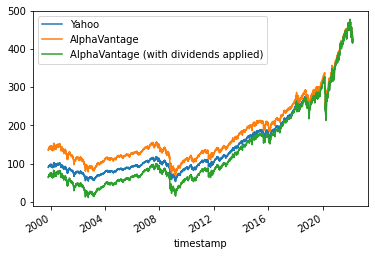

In [16]:
for c in ['high', 'low', 'open', 'close']:
    spy_daily_r[c] = spy_daily_r[c] - spy_daily_r['total_dividend']

spy_yf_short['Close'].plot(label="Yahoo")
spy_daily['close'].plot(label="AlphaVantage")
spy_daily_r['close'].plot(label="AlphaVantage (with dividends applied)")
plt.legend()

## Actually calculating dividends
Oh no, it didn't work! The dividends applied to the AlphaVantage data is not matching Yahoo! What could be the issue? After doing a little digging, I realized my naive approach to backing out dividends from the price is not the correct way to do it. Consider the following example: let's say a stock is priced at `$10` and pays a `$0.25` quarterly dividend. The price stays at `$10` for 15 years. What will the adjusted price be? If we only subtracted the cumulative dividend from the current price, we would end up with a negative price of `$-5`, or `$10-(4x$0.25)*15`. To keep prices above 0, something else must be done.

It turns out that the way Yahoo! calculates this is to use a standardized technique from the Center for Research in Security Prices (CRSP) that is somewhat poorly explained [here](https://help.yahoo.com/kb/SLN28256.html). Instead of subtracting the total dividend value from the price, a multiplier is calculated based on the dividend and the most recent close price before the dividend was paid. This factor, which is always greater than 0 and less than 1, will be applied to all the prices until the next dividend going back in time. On the next dividend, a new factor is calculated.

The factor is always calculated as `1 - (dividend/price)`, and all the factors are multiplied together going backwards in time, then applied to all the prices. Note the accumulated factor only changes once a quarter.

To apply this technique in pandas, we just need to get the right price and the dividend for each row. The price will be the close price from the day before the dividend. 

Note that programmers might be tempted to write a function that iterates over all the rows in the `DataFrame` to calculate this value. If you come with typical Python programming experience, that will probably seem pretty straightforward to you. But a better way to do it is to create a vectorized solution. For more on why this is better, check out [this article](https://www.wrighters.io/how-to-iterate-over-dataframe-rows-and-should-you/).

First, we need to find the close price from the day before the dividend. Like earlier, we use a boolean index, but we shift it one day back.

In [17]:
# shift the dividends back 1 day, use them to obtain the rows with the prices to use
spy_daily_d = spy_daily.copy()
spy_daily_d.loc[~pd.isnull(spy_daily_d['dividend'].shift(-1)), 'close']

timestamp
1999-12-16    142.1250
2000-03-16    146.3437
2000-06-15    148.1562
2000-09-14    149.6406
2000-12-14    134.4062
                ...   
2020-12-17    372.2400
2021-03-18    391.4800
2021-06-17    421.9700
2021-09-16    447.1700
2021-12-16    466.4500
Name: close, Length: 90, dtype: float64

Note that these prices have an index value (a date) that is the date where this price will start to be used going back in time. We now just need to calculate our factor, using the dividend with each price. We grab the dividends using the same concept as above.

In [18]:
spy_daily_d.loc[~pd.isnull(spy_daily_d['dividend']), 'dividend']

timestamp
1999-12-17    0.348
2000-03-17    0.371
2000-06-16    0.348
2000-09-15    0.375
2000-12-15    0.411
              ...  
2020-12-18    1.580
2021-03-19    1.278
2021-06-18    1.376
2021-09-17    1.428
2021-12-17    1.633
Name: dividend, Length: 90, dtype: float64

Note that the index is off by one day here, this is the date of the dividend itself. We can now calculate the factor, but we have to watch our indexes! We want to use the index from the price, not the index from the dividend, so we just grab the `values` from the dividend. We can anow calculate the factor all in one go.

In [19]:
factor = 1 - (spy_daily_d.loc[~pd.isnull(spy_daily_d['dividend']), 'dividend'].values/
              spy_daily_d.loc[~pd.isnull(spy_daily_d['dividend'].shift(-1)), 'close'])
factor

timestamp
1999-12-16    0.997551
2000-03-16    0.997465
2000-06-15    0.997651
2000-09-14    0.997494
2000-12-14    0.996942
                ...   
2020-12-17    0.995755
2021-03-18    0.996735
2021-06-17    0.996739
2021-09-16    0.996807
2021-12-16    0.996499
Name: close, Length: 90, dtype: float64

You can see here that the we now have a series of factors and the date when they take effect. Our last step is to apply these factors going back in time by multiplying them together. You can do this in pandas using `cumprod`, which works like `cumsum` but instead of summing, it makes a product. Again, we need to do the `sort_index` thing we did in our incorrect solution to get this going backwards instead of forwards in time.

In [20]:
factor.sort_index(ascending=False).cumprod().sort_index()

timestamp
1999-12-16    0.664324
2000-03-16    0.665955
2000-06-15    0.667648
2000-09-14    0.669219
2000-12-14    0.670901
                ...   
2020-12-17    0.982657
2021-03-18    0.986846
2021-06-17    0.990078
2021-09-16    0.993317
2021-12-16    0.996499
Name: close, Length: 90, dtype: float64

Just spot checking this, it makes sense. The factor should be smaller the further back we go, making the prices in the past lower so our returns are higher due to the effect of the dividends. Finally, let's apply that to our prices and see if we can match the Yahoo! data. 

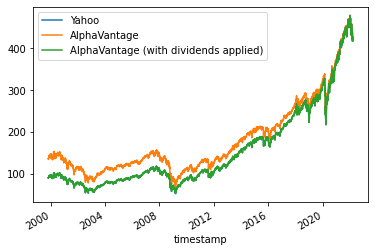

In [21]:
# second attempt. Make a new copy of the original source data that is pristine
spy_daily_r2 = spy_daily.copy()
spy_daily_r2['factor'] = factor.sort_index(ascending=False).cumprod().sort_index()
# backfill the missing values with the most recent value (i.e the factor from that dividend)
spy_daily_r2['factor'].bfill(inplace=True)  
spy_daily_r2['factor'].fillna(1, inplace=True)  # base case

for c in ['high', 'low', 'open', 'close']:
    spy_daily_r2[c] = spy_daily_r2[c] * spy_daily_r2['factor']

spy_yf_short['Close'].plot(label="Yahoo")
spy_daily['close'].plot(label="AlphaVantage")
spy_daily_r2['close'].plot(label="AlphaVantage (with dividends applied)")
plt.legend()

Now we have a match! Now I'll confess that getting this right took me quite a bit of debugging. Here's a few tips on how to not make the same mistakes I did in figuring this out.

### Don't reuse data that you've modified.
If you've pulled data from an original source (in my case Yahoo! and AlphaVantage) and then modified it in a failed attempt at doing something, don't use that `DataFrame` for another attempt from scratch. In my case, I had re-used my data from the incorrect method of backing out dividends in my corrected implementation, and I was still wrong (because my prices had been modified). Make sure you can pull data from start to finish and know all the modifications. One way to do this is split up your notebooks into separate notebooks for each attempt.

### Make good use of visualizations for errors.
If you have two data sets that should match, plot their ratio to see how close they are to each other. If they aren't really close to 1, you know you have a problem. Then look for dates where they diverge. For me, I noticed these divergences happened on the dividend dates, so I realized I had corrupted the data at one point.

### Consider `matplotlib notebook`
By default, matplotlib plots are shown inline in Jupyter. There's a special magic in Jupyter that will generate interactive plots in your browser, `%matplotlib notebook`. Put this at the top of the notebook cell where you're plotting data that you want to interact with.  You can zoom in on discrepancies.

### Look at an individual row in detail
I did a manual calcuation on single rows until I had convinced myself what the correct values should be. Once I have a know good result, I could look at those rows to double check my calculations. You might even put this in a spreadsheet if you find that helpful.

OK, we've talked about this enough. Hopefully at this point you know more about dividends than you did when you started, and that they should not be ignored!

What else could contribute to overnight returns dominating intraday returns? I'll look at a few more potential reasons in future articles. Those articles will include code and techniques to download, clean, and analyze the data, just like this one.